In [ ]:

import pandas as pd

from google.colab import files
import pandas as pd
data_to_load = files.upload()
import io

# Replace 'path_to_your_file' with the path to the dataset file you uploaded
df  = pd.read_excel(io.BytesIO(data_to_load['labeled_dataset.xlsx']))
df.head()

Saving labeled_dataset.xlsx to labeled_dataset.xlsx


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
3,3,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,1,1,Non-biased,No agreement,A professor who teaches climate change classes...,['legitimate']
4,4,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."


In [ ]:
print(df['Label_bias'].unique())

['Biased' 'Non-biased' 'No agreement']


In [ ]:

# Deleting rows where 'Label_bias' is 'No agreement'
df = df.loc[df['Label_bias'] != 'No agreement']

# Alternatively, using query method
# df_filtered = df.query("Label_bias != 'No agreement'")

print(df)

      Unnamed: 0                                           sentence  \
0              0  YouTube is making clear there will be no “birt...   
1              1  The increasingly bitter dispute between Americ...   
2              2  So while there may be a humanitarian crisis dr...   
3              3  A professor who teaches climate change classes...   
4              4  Looking around the United States, there is nev...   
...          ...                                                ...   
1695        1695  In every case legislators are being swarmed by...   
1696        1696  Polls show the transgender ideology is deeply ...   
1697        1697  Democrats and Republicans stood and applauded ...   
1698        1698  As a self-described Democratic socialist, Sen....   
1699        1699  During the segment, Colbert also bemoaned the ...   

                                              news_link      outlet  \
0     https://eu.usatoday.com/story/tech/2020/02/03/...   usa-today   
1    

In [ ]:
print(df['Label_bias'].unique())

['Biased' 'Non-biased']


In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


# Step 2: Preprocess the data
# Encode the labels
encoder = LabelEncoder()
y = encoder.fit_transform(df['Label_bias'])

# Step 3: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], y, test_size=0.2, random_state=42)

# Step 4: Convert text data into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = svm.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


Accuracy: 0.6881028938906752
Classification Report:
              precision    recall  f1-score   support

      Biased       0.72      0.87      0.79       208
  Non-biased       0.55      0.33      0.41       103

    accuracy                           0.69       311
   macro avg       0.64      0.60      0.60       311
weighted avg       0.67      0.69      0.66       311



In [ ]:
!pip install gensim scikit-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset
# df = pd.read_excel('/path/to/your/dataset.xlsx')  # Uncomment and adjust the path

# Encode labels
encoder = LabelEncoder()
labels = encoder.fit_transform(df['Label_bias'])

# Split data
sentences_train, sentences_test, y_train, y_test = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tag documents
train_tagged = [TaggedDocument(words=sentence.split(), tags=[i]) for i, sentence in enumerate(sentences_train)]

# Initialize and train a Doc2Vec model
model_d2v = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
model_d2v.build_vocab(train_tagged)
model_d2v.train(train_tagged, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)


In [ ]:
# Function to vectorize a list of sentences
def vectorize_sentences(model, sentences):
    return [model.infer_vector(sentence.split()) for sentence in sentences]

X_train = vectorize_sentences(model_d2v, sentences_train)
X_test = vectorize_sentences(model_d2v, sentences_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions
y_pred = best_rf.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6816720257234726
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.80       208
           1       0.57      0.17      0.26       103

    accuracy                           0.68       311
   macro avg       0.63      0.55      0.53       311
weighted avg       0.65      0.68      0.62       311



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
# Predict the class for X_test
y_pred = best_rf.predict(X_test)

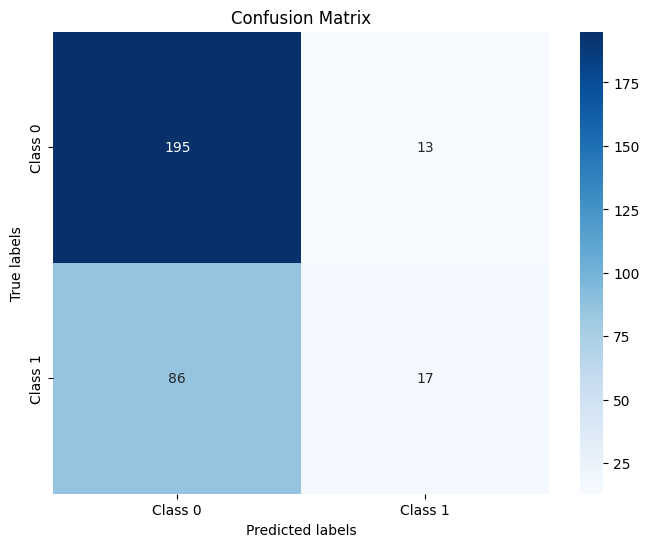

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
